In [15]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision as tv

from torch.cuda.amp import GradScaler, autocast

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [23]:
# Создание класса для кастомного датасета
# 2 класса (коты/собаки)

class Dataset2Class(torch.utils.data.Dataset):
    def __init__(self, path_dir1: str, path_dir2: str):
        super().__init__()
        
        self.path_dir1 = path_dir1
        self.path_dir2 = path_dir2
        
        self.dir1_list = sorted(os.listdir(self.path_dir1))
        self.dir2_list = sorted(os.listdir(self.path_dir2))
        
    def __len__(self):
        return len(self.dir1_list) + len(self.dir2_list)
        
    def __getitem__(self, index):
        if index < len(self.dir1_list):
            class_id = 0 
            img_path = os.path.join(self.path_dir1, self.dir1_list[index])
        else:
            class_id = 1
            index -= len(self.dir1_list)
            img_path = os.path.join(self.path_dir2, self.dir2_list[index])
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)        
        img /= 255.0
        
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        img = img.transpose((2, 0, 1))
        
        
        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor([class_id])
        
        return {"img": t_img, "label": t_class_id}
    

In [24]:
# Загрузка локальных путей к картинкам и превращение в датасет

train_dogs_path = "../cats_dogs_dataset/training_set/dogs/"
train_cats_path = "../cats_dogs_dataset/training_set/cats/"

test_dogs_path = "../cats_dogs_dataset/test_set/dogs/"
test_cats_path = "../cats_dogs_dataset/test_set/cats/"

train_dataset = Dataset2Class(train_dogs_path, train_cats_path)
test_dataset = Dataset2Class(test_dogs_path, test_cats_path)

In [68]:
# Задаем dataloader

batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True,
    drop_last=True
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=True,
    drop_last=False
)

In [69]:
len(train_dataset)

8000

In [70]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2) # inplace=True для экономии памяти
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        
        self.conv0  = nn.Conv2d(3, 128, kernel_size=(3,3), stride=1, padding=0)
        self.conv1  = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=0)
        self.conv2  = nn.Conv2d(128, 128, kernel_size=(3,3), stride=1, padding=0)
        self.conv3  = nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=0)        
        
        self.adaptivepool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256, 20)
        self.linear2 = nn.Linear(20, 2)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)
        
        out = self.conv3(out)
        out = self.act(out)
        
        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)
        
        return out

In [118]:
class ResBlock(nn.Module):
    def __init__(self, nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm0 = nn.BatchNorm2d(nc)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, nc, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(nc)
        
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        
        return self.act(x + out)
    
# Можно так же попробоать выход return x + out
# или x + 0.2*out , но такое обычно используется при большом количестве слоев

In [119]:
class ResTruck(nn.Module):
    def __init__(self, nc, num_blocks):
        super().__init__()
        
        truck = []
        for i in range(num_blocks):
            truck += [ResBlock(nc)]
            
        self.truck = nn.Sequential(*truck)
    
    def forward(self, x):
        return self.truck(x)

In [120]:
class PsevdoResNet(nn.Module):
    def __init__(self, in_nc, nc, out_nc):
        super().__init__()
        
        self.conv0 = nn.Conv2d(in_nc, nc, kernel_size=7, stride=2)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.layer1 = ResTruck(nc, 3)
        self.conv1 = nn.Conv2d(nc, 2*nc, 3, padding=1, stride=2)
        self.layer2 = ResTruck(2*nc, 4)
        self.conv2 = nn.Conv2d(2*nc, 4*nc, 3, padding=1, stride=2)
        self.layer3 = ResTruck(4*nc, 6)
        self.conv3 = nn.Conv2d(4*nc, 4*nc, 3, padding=1, stride=2)
        self.layer4 = ResTruck(4*nc, 3)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4*nc, out_nc)
        
    def forward(self, x):
        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.conv1(out)
        out = self.layer2(out)
        out = self.conv2(out)
        out = self.layer3(out)
        out = self.conv3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        
        return out

In [121]:
# model = ConvNet()
model = PsevdoResNet(3, 32, 2)

In [122]:
for sample in train_dataloader:
    img = sample["img"]
    label = sample["label"]
    
    model(img)
    break

In [123]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [129]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
    return answer.mean()

In [125]:
use_amp = True
scaler = torch.cuda.amp.GradScaler() # только для GPU

/Users/egoryakovlev/opt/anaconda3/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [126]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

In [130]:
loss_epoch_list = []
acc_epoch_list = []
epochs = 10

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for sample in (pbar := tqdm(train_dataloader)):
        img, label = sample["img"], sample["label"].squeeze()
        optimizer.zero_grad()
        label = F.one_hot(label, 2).float()
        
        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)
        
        scaler.scale(loss).backward()
        
        loss_item = loss.item()
        loss_val += loss_item
        
        scaler.step(optimizer)
        scaler.update()
        
        acc_current = accuracy(pred, label)
        acc_val += acc_current
        
        pbar.set_description(f"loss: {loss_item:.5f}/t accuracy: {acc_current:.3f}")    
    
    loss_epoch_list += [loss_val/len(train_dataloader)]
    acc_epoch_list += [acc_val/len(train_dataloader)]   
    print(loss_val/len(train_dataloader))
    print(acc_val/len(train_dataloader))

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/5f/qvq_31yx7gq6_br4st_jt1y80000gp/T/ipykernel_9197/1416373963.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(pred.detach()).numpy().argmax(1) == label.numpy().argmax(1)
loss: 0.62413/t accuracy: 0.594: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


0.6788456764221191
0.580125


loss: 0.64678/t accuracy: 0.656: 100%|██████████| 250/250 [01:46<00:00,  2.35it/s]


0.654201611995697
0.621


loss: 0.55290/t accuracy: 0.719: 100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


0.6335812602043152
0.636125


loss: 0.66024/t accuracy: 0.750: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


0.6113580302000046
0.66275


loss: 0.55225/t accuracy: 0.781: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


0.5743867887258529
0.7015


loss: 0.44458/t accuracy: 0.844: 100%|██████████| 250/250 [01:52<00:00,  2.23it/s]


0.5413506006002426
0.7335


loss: 0.40065/t accuracy: 0.781: 100%|██████████| 250/250 [01:49<00:00,  2.27it/s]


0.5043584195375442
0.752375


loss: 0.45204/t accuracy: 0.812: 100%|██████████| 250/250 [01:48<00:00,  2.31it/s]


0.481726838350296
0.7625


loss: 0.34202/t accuracy: 0.875: 100%|██████████| 250/250 [01:50<00:00,  2.26it/s]


0.4505758277773857
0.791


loss: 0.54690/t accuracy: 0.688: 100%|██████████| 250/250 [02:04<00:00,  2.00it/s]

0.4112710210084915
0.808625


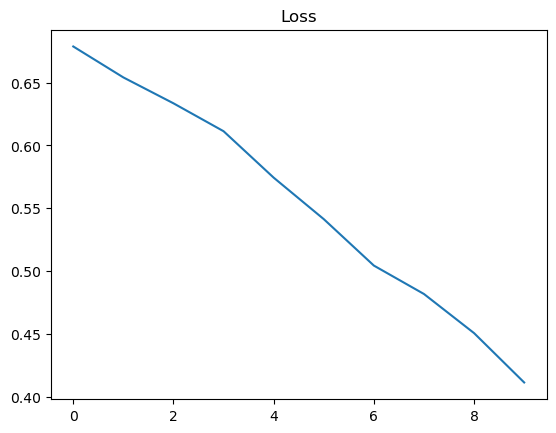

In [131]:
plt.title("Loss")
plt.plot(loss_epoch_list)

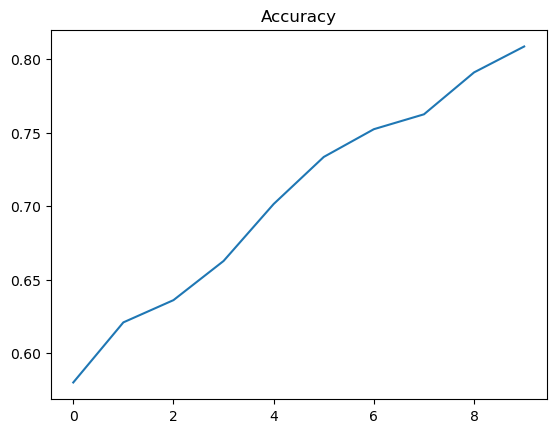

In [133]:
plt.title("Accuracy")
plt.plot(acc_epoch_list)